In [1]:
import pandas as pd
import numpy as np
import shutil
import multiprocessing
from datetime import datetime

import tensorflow as tf
from tensorflow.python.feature_column import feature_column
from tensorflow.contrib.learn import learn_runner
from tensorflow import data

print(tf.__version__)

/Users/khalidsalama/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


1.4.0


## TF Custom Estimator to Build a NN Autoencoder for Feature Extraction

In [2]:
MODEL_NAME = 'auto-encoder-01'

TRAIN_DATA_FILES_PATTERN = 'data/data-*.csv'

RESUME_TRAINING = False

MULTI_THREADING = True

## 1. Define Dataset Metadata

In [3]:
FEATURE_COUNT = 64

HEADER = ['key']
HEADER_DEFAULTS = [[0]]
UNUSED_FEATURE_NAMES = ['key']
CLASS_FEATURE_NAME = 'CLASS'
FEATURE_NAMES = []  

for i in range(FEATURE_COUNT):
    HEADER += ['x_{}'.format(str(i+1))]
    FEATURE_NAMES += ['x_{}'.format(str(i+1))]
    HEADER_DEFAULTS += [[0.0]]

HEADER += [CLASS_FEATURE_NAME]
HEADER_DEFAULTS += [['NA']]

print("Header: {}".format(HEADER))
print("Features: {}".format(FEATURE_NAMES))
print("Class Feature: {}".format(CLASS_FEATURE_NAME))
print("Unused Features: {}".format(UNUSED_FEATURE_NAMES))

Header: ['key', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19', 'x_20', 'x_21', 'x_22', 'x_23', 'x_24', 'x_25', 'x_26', 'x_27', 'x_28', 'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_34', 'x_35', 'x_36', 'x_37', 'x_38', 'x_39', 'x_40', 'x_41', 'x_42', 'x_43', 'x_44', 'x_45', 'x_46', 'x_47', 'x_48', 'x_49', 'x_50', 'x_51', 'x_52', 'x_53', 'x_54', 'x_55', 'x_56', 'x_57', 'x_58', 'x_59', 'x_60', 'x_61', 'x_62', 'x_63', 'x_64', 'CLASS']
Features: ['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19', 'x_20', 'x_21', 'x_22', 'x_23', 'x_24', 'x_25', 'x_26', 'x_27', 'x_28', 'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_34', 'x_35', 'x_36', 'x_37', 'x_38', 'x_39', 'x_40', 'x_41', 'x_42', 'x_43', 'x_44', 'x_45', 'x_46', 'x_47', 'x_48', 'x_49', 'x_50', 'x_51', 'x_52', 'x_53', 'x_54', 'x_55', 'x_56', 'x_57', 'x_58', 'x_59'

## 2. Define CSV Data Input Function

In [4]:
def parse_csv_row(csv_row):
    
    columns = tf.decode_csv(csv_row, record_defaults=HEADER_DEFAULTS)
    features = dict(zip(HEADER, columns))
    
    for column in UNUSED_FEATURE_NAMES:
        features.pop(column)

    target = features.pop(CLASS_FEATURE_NAME)

    return features, target

In [5]:
def csv_input_fn(files_name_pattern, mode=tf.estimator.ModeKeys.EVAL, 
                 skip_header_lines=0, 
                 num_epochs=None, 
                 batch_size=200):
    
    shuffle = True if mode == tf.estimator.ModeKeys.TRAIN else False
    
    print("")
    print("* data input_fn:")
    print("================")
    print("Input file(s): {}".format(files_name_pattern))
    print("Batch size: {}".format(batch_size))
    print("Epoch Count: {}".format(num_epochs))
    print("Mode: {}".format(mode))
    print("Shuffle: {}".format(shuffle))
    print("================")
    print("")
    
    file_names = tf.matching_files(files_name_pattern)

    dataset = data.TextLineDataset(filenames=file_names)
    dataset = dataset.skip(skip_header_lines)
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=2 * batch_size + 1)
        
    num_threads = multiprocessing.cpu_count() if MULTI_THREADING else 1
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda csv_row: parse_csv_row(csv_row), num_parallel_calls=num_threads)
    
    dataset = dataset.repeat(num_epochs)
    iterator = dataset.make_one_shot_iterator()
    
    features, target = iterator.get_next()

    return features, target

In [6]:
features, target = csv_input_fn(files_name_pattern="")
print("Feature read from CSV: {}".format(list(features.keys())))
print("Target read from CSV: {}".format(target))


* data input_fn:
Input file(s): 
Batch size: 200
Epoch Count: None
Mode: eval
Shuffle: False

Feature read from CSV: ['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10', 'x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_16', 'x_17', 'x_18', 'x_19', 'x_20', 'x_21', 'x_22', 'x_23', 'x_24', 'x_25', 'x_26', 'x_27', 'x_28', 'x_29', 'x_30', 'x_31', 'x_32', 'x_33', 'x_34', 'x_35', 'x_36', 'x_37', 'x_38', 'x_39', 'x_40', 'x_41', 'x_42', 'x_43', 'x_44', 'x_45', 'x_46', 'x_47', 'x_48', 'x_49', 'x_50', 'x_51', 'x_52', 'x_53', 'x_54', 'x_55', 'x_56', 'x_57', 'x_58', 'x_59', 'x_60', 'x_61', 'x_62', 'x_63', 'x_64']
Target read from CSV: Tensor("IteratorGetNext:64", shape=(?,), dtype=string)


## 3. Define Feature Columns

In [7]:
def get_feature_columns():

    feature_columns = {feature_name: tf.feature_column.numeric_column(feature_name)
                       for feature_name in FEATURE_NAMES}

    return feature_columns

## 4. Define Autoencoder Model Function

In [8]:
def autoencoder_model_fn(features, labels, mode, params):
    
    feature_columns = list(get_feature_columns().values())
    
    input_layer_size = len(feature_columns)
    
    encoder_hidden_units = params.encoder_hidden_units
    
    # decoder units are the reverse of the encoder units, without the middle layer (redundant)
    decoder_hidden_units = encoder_hidden_units.copy()  
    decoder_hidden_units.reverse()
    decoder_hidden_units.pop(0)
    
    output_layer_size = len(FEATURE_NAMES)
    
    he_initialiser = tf.contrib.layers.variance_scaling_initializer()
    l2_regulariser = tf.contrib.layers.l2_regularizer(scale=params.l2_reg)
    
  
    print("[{}]->{}-{}->[{}]".format(len(feature_columns)
                                     ,encoder_hidden_units
                                     ,decoder_hidden_units,
                                     output_layer_size))

    is_training = (mode == tf.estimator.ModeKeys.TRAIN)
    
    # input layer
    input_layer = tf.feature_column.input_layer(features=features, 
                                                feature_columns=feature_columns)
    
    # Adding Gaussian Noise to input layer
    noisy_input_layer = input_layer + (params.noise_level * tf.random_normal(tf.shape(input_layer)))
    
    # Dropout layer
    dropout_layer = tf.layers.dropout(inputs=noisy_input_layer, 
                                     rate=params.dropout_rate, 
                                     training=is_training)

#     # Dropout layer without Gaussian Nosing
#     dropout_layer = tf.layers.dropout(inputs=input_layer, 
#                                       rate=params.dropout_rate, 
#                                       training=is_training)

    # Encoder layers stack
    encoding_hidden_layers = tf.contrib.layers.stack(inputs= dropout_layer,
                                                     layer= tf.contrib.layers.fully_connected,
                                                     stack_args=encoder_hidden_units,
                                                     #weights_initializer = he_init,
                                                     weights_regularizer =l2_regulariser,
                                                     activation_fn = tf.nn.relu
                                                    )
    # Decoder layers stack
    decoding_hidden_layers = tf.contrib.layers.stack(inputs=encoding_hidden_layers,
                                                     layer=tf.contrib.layers.fully_connected,                
                                                     stack_args=decoder_hidden_units,
                                                     #weights_initializer = he_init,
                                                     weights_regularizer =l2_regulariser,
                                                     activation_fn = tf.nn.relu
                                                    )
    # Output (reconstructed) layer
    output_layer = tf.layers.dense(inputs=decoding_hidden_layers, 
                             units=output_layer_size, activation=None)
    
    # Encoding output (i.e., extracted features) reshaped
    encoding_output = tf.squeeze(encoding_hidden_layers)
    
    # Reconstruction output reshaped (for loss calculation)
    reconstruction_output =  tf.squeeze(output_layer)
    
    # Provide an estimator spec for `ModeKeys.PREDICT`.
    if mode == tf.estimator.ModeKeys.PREDICT:
        
        # Convert predicted_indices back into strings
        predictions = {
            'encoding': encoding_output,
            'reconstruction': reconstruction_output
        }
        export_outputs = {
            'predict': tf.estimator.export.PredictOutput(predictions)
        }
        
        # Provide an estimator spec for `ModeKeys.PREDICT` modes.
        return tf.estimator.EstimatorSpec(mode,
                                          predictions=predictions,
                                          export_outputs=export_outputs)
    
    # Define loss based on reconstruction and regularization
    loss = tf.losses.mean_squared_error(tf.squeeze(input_layer), reconstruction_output) 
    loss = loss + tf.losses.get_regularization_loss()
                         
    # Create Optimiser
    optimizer = tf.train.AdamOptimizer(params.learning_rate)

    # Create training operation
    train_op = optimizer.minimize(
        loss=loss, global_step=tf.train.get_global_step())

    # Calculate root mean squared error as additional eval metric
    eval_metric_ops = {
        "rmse": tf.metrics.root_mean_squared_error(
            tf.squeeze(input_layer), reconstruction_output)
    }
                                                     
    # Provide an estimator spec for `ModeKeys.EVAL` and `ModeKeys.TRAIN` modes.
    estimator_spec = tf.estimator.EstimatorSpec(mode=mode,
                                                loss=loss,
                                                train_op=train_op,
                                                eval_metric_ops=eval_metric_ops)
    return estimator_spec


def create_estimator(run_config, hparams):
    estimator = tf.estimator.Estimator(model_fn=autoencoder_model_fn, 
                                  params=hparams, 
                                  config=run_config)
    
    print("")
    print("Estimator Type: {}".format(type(estimator)))
    print("")

    return estimator

## 5. Run Experiment

### a. Create Experiment Function

In [9]:
def generate_experiment_fn(**experiment_args):

    def _experiment_fn(run_config, hparams):

        train_input_fn = lambda: csv_input_fn(
            TRAIN_DATA_FILES_PATTERN,
            mode = tf.contrib.learn.ModeKeys.TRAIN,
            num_epochs=hparams.num_epochs,
            batch_size=hparams.batch_size
        )

        eval_input_fn = lambda: csv_input_fn(
            TRAIN_DATA_FILES_PATTERN,
            mode=tf.contrib.learn.ModeKeys.EVAL,
            num_epochs=1,
            batch_size=hparams.batch_size
        )

        estimator = create_estimator(run_config, hparams)

        return tf.contrib.learn.Experiment(
            estimator,
            train_input_fn=train_input_fn,
            eval_input_fn=eval_input_fn,
            eval_steps=None,
            **experiment_args
        )

    return _experiment_fn

### b. Set the parameters

In [10]:
TRAIN_SIZE = 2000
NUM_EPOCHS = 1000
BATCH_SIZE = 100
NUM_EVAL = 10
CHECKPOINT_STEPS = int((TRAIN_SIZE/BATCH_SIZE) * (NUM_EPOCHS/NUM_EVAL))

hparams  = tf.contrib.training.HParams(
    num_epochs = NUM_EPOCHS,
    batch_size = BATCH_SIZE,
    encoder_hidden_units=[30,3],
    learning_rate = 0.01,
    l2_reg = 0.0001,
    noise_level = 0.0,
    dropout_rate = 0.1)

model_dir = 'trained_models/{}'.format(MODEL_NAME)

run_config = tf.contrib.learn.RunConfig(
    save_checkpoints_steps=CHECKPOINT_STEPS,
    tf_random_seed=19830610,
    model_dir=model_dir
)

print(hparams)
print("Model Directory:", run_config.model_dir)
print("")
print("Dataset Size:", TRAIN_SIZE)
print("Batch Size:", BATCH_SIZE)
print("Steps per Epoch:",TRAIN_SIZE/BATCH_SIZE)
print("Total Steps:", (TRAIN_SIZE/BATCH_SIZE)*NUM_EPOCHS)
print("Required Evaluation Steps:", NUM_EVAL) 
print("That is 1 evaluation step after each",NUM_EPOCHS/NUM_EVAL," epochs")
print("Save Checkpoint After",CHECKPOINT_STEPS,"steps")

[('batch_size', 100), ('dropout_rate', 0.1), ('encoder_hidden_units', [30, 3]), ('l2_reg', 0.0001), ('learning_rate', 0.01), ('noise_level', 0.0), ('num_epochs', 1000)]
Model Directory: trained_models/auto-encoder-01

Dataset Size: 2000
Batch Size: 100
Steps per Epoch: 20.0
Total Steps: 20000.0
Required Evaluation Steps: 10
That is 1 evaluation step after each 100.0  epochs
Save Checkpoint After 2000 steps


### c. Run the experiment using learn_runner

In [11]:
if not RESUME_TRAINING:
    print("Removing previous artifacts...")
    shutil.rmtree(model_dir, ignore_errors=True)
else:
    print("Resuming training...") 


tf.logging.set_verbosity(tf.logging.INFO)

time_start = datetime.utcnow() 
print("Experiment started at {}".format(time_start.strftime("%H:%M:%S")))
print(".......................................") 

learn_runner.run(
    experiment_fn=generate_experiment_fn(
    ),
    run_config=run_config,
    schedule="train_and_evaluate", #'train_and_evaluate'
    hparams=hparams
)

time_end = datetime.utcnow() 
print(".......................................")
print("Experiment finished at {}".format(time_end.strftime("%H:%M:%S")))
print("")
time_elapsed = time_end - time_start
print("Experiment elapsed time: {} seconds".format(time_elapsed.total_seconds()))
    

Removing previous artifacts...
Experiment started at 19:20:43
.......................................
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x121ab5a20>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': 19830610, '_save_summary_steps': 100, '_save_checkpoints_secs': None, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': 2000, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'trained_models/auto-encoder-01'}

Estimator Type: <class 'tensorflow.python.estimator.estimator.Estimator'>

Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.

* data input_fn:
Input file(s): data/data-*.csv
Batch size: 100
Epoch Count: 1

INFO:tensorflow:loss = 18.7836, step = 4701 (0.730 sec)
INFO:tensorflow:global_step/sec: 133.155
INFO:tensorflow:loss = 18.1432, step = 4801 (0.750 sec)
INFO:tensorflow:global_step/sec: 134.631
INFO:tensorflow:loss = 18.5973, step = 4901 (0.745 sec)
INFO:tensorflow:global_step/sec: 132.684
INFO:tensorflow:loss = 18.8942, step = 5001 (0.752 sec)
INFO:tensorflow:global_step/sec: 135.948
INFO:tensorflow:loss = 19.7179, step = 5101 (0.735 sec)
INFO:tensorflow:global_step/sec: 136.043
INFO:tensorflow:loss = 18.4183, step = 5201 (0.735 sec)
INFO:tensorflow:global_step/sec: 133.034
INFO:tensorflow:loss = 18.9556, step = 5301 (0.751 sec)
INFO:tensorflow:global_step/sec: 134.138
INFO:tensorflow:loss = 18.2598, step = 5401 (0.746 sec)
INFO:tensorflow:global_step/sec: 134.692
INFO:tensorflow:loss = 20.168, step = 5501 (0.742 sec)
INFO:tensorflow:global_step/sec: 134.928
INFO:tensorflow:loss = 18.9459, step = 5601 (0.741 sec)
INFO:tensorflow:global_step/sec: 133.344
INFO:tensorflow:loss = 19.2701,

INFO:tensorflow:global_step/sec: 128.565
INFO:tensorflow:loss = 19.4015, step = 11201 (0.779 sec)
INFO:tensorflow:global_step/sec: 110.455
INFO:tensorflow:loss = 18.9923, step = 11301 (0.904 sec)
INFO:tensorflow:global_step/sec: 132.227
INFO:tensorflow:loss = 18.753, step = 11401 (0.756 sec)
INFO:tensorflow:global_step/sec: 133.664
INFO:tensorflow:loss = 19.5469, step = 11501 (0.748 sec)
INFO:tensorflow:global_step/sec: 133.3
INFO:tensorflow:loss = 19.2192, step = 11601 (0.750 sec)
INFO:tensorflow:global_step/sec: 111.109
INFO:tensorflow:loss = 19.3636, step = 11701 (0.900 sec)
INFO:tensorflow:global_step/sec: 115.101
INFO:tensorflow:loss = 17.8409, step = 11801 (0.870 sec)
INFO:tensorflow:global_step/sec: 130.435
INFO:tensorflow:loss = 18.5233, step = 11901 (0.767 sec)
INFO:tensorflow:Saving checkpoints for 12001 into trained_models/auto-encoder-01/model.ckpt.
INFO:tensorflow:global_step/sec: 49.0935

* data input_fn:
Input file(s): data/data-*.csv
Batch size: 100
Epoch Count: 1
Mode:

INFO:tensorflow:global_step/sec: 128.467
INFO:tensorflow:loss = 18.3316, step = 17601 (0.778 sec)
INFO:tensorflow:global_step/sec: 129.369
INFO:tensorflow:loss = 17.4407, step = 17701 (0.774 sec)
INFO:tensorflow:global_step/sec: 128.354
INFO:tensorflow:loss = 17.6305, step = 17801 (0.779 sec)
INFO:tensorflow:global_step/sec: 126.157
INFO:tensorflow:loss = 18.8895, step = 17901 (0.792 sec)
INFO:tensorflow:Saving checkpoints for 18001 into trained_models/auto-encoder-01/model.ckpt.
INFO:tensorflow:global_step/sec: 48.8043

* data input_fn:
Input file(s): data/data-*.csv
Batch size: 100
Epoch Count: 1
Mode: eval
Shuffle: False

[64]->[30, 3]-[30]->[64]
INFO:tensorflow:Starting evaluation at 2017-11-22-19:23:56
INFO:tensorflow:Restoring parameters from trained_models/auto-encoder-01/model.ckpt-18001
INFO:tensorflow:Finished evaluation at 2017-11-22-19:23:57
INFO:tensorflow:Saving dict for global step 18001: global_step = 18001, loss = 17.9375, rmse = 4.23275
INFO:tensorflow:Validation (ste

## 6. Use the trained model to encode data (prediction)

In [12]:
import itertools

DATA_SIZE = 2000

input_fn = lambda: csv_input_fn(
    TRAIN_DATA_FILES_PATTERN,
    mode=tf.contrib.learn.ModeKeys.INFER,
    num_epochs=1,
    batch_size=500
)

estimator = create_estimator(run_config, hparams)

predictions = estimator.predict(input_fn=input_fn)
predictions = itertools.islice(predictions, DATA_SIZE)
predictions = list(map(lambda item: list(item["encoding"]), predictions))

print(predictions[:5])

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x121ab5a20>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': 19830610, '_save_summary_steps': 100, '_save_checkpoints_secs': None, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': 2000, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'trained_models/auto-encoder-01'}

Estimator Type: <class 'tensorflow.python.estimator.estimator.Estimator'>


* data input_fn:
Input file(s): data/data-*.csv
Batch size: 500
Epoch Count: 1
Mode: infer
Shuffle: False

[64]->[30, 3]-[30]->[64]
INFO:tensorflow:Restoring parameters from trained_models/auto-encoder-01/model.ckpt-20000
[[10.613751, 21.388153, 9.109767], [0.0, 6.141

## Visualise Encoded Data

In [13]:
y = pd.read_csv("data/data-01.csv", header=None, index_col=0)[65]

data_reduced = pd.DataFrame(predictions, columns=['c1','c2','c3'])
data_reduced['class'] = y
data_reduced.head()

,c1,c2,c3,class
0,10.613751,21.388153,9.109767,2
1,0.000000,6.141694,45.451698,0
2,10.163795,6.520020,21.493673,0
3,28.593414,30.766495,10.593480,2
4,16.369936,23.123470,10.659847,2


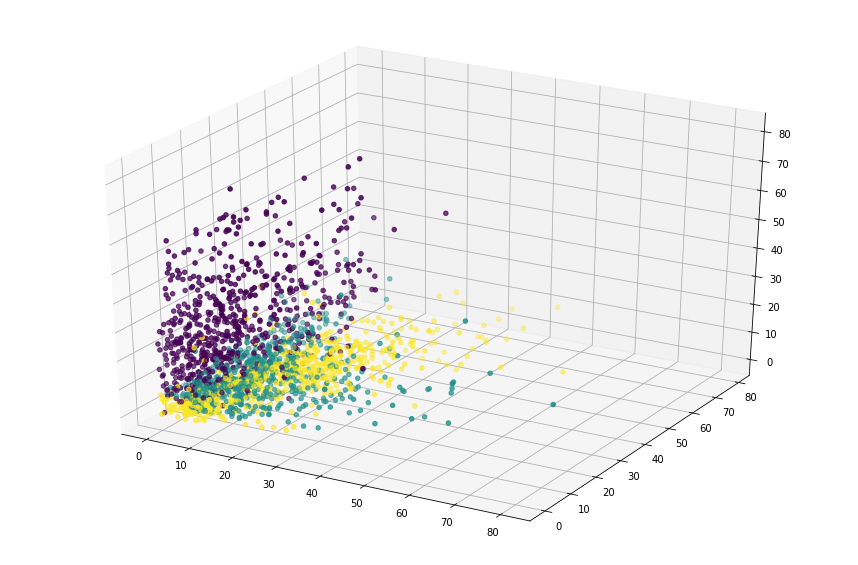

In [14]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=data_reduced.c1, ys=data_reduced.c2, zs=data_reduced.c3, c=data_reduced['class'], marker='o')
plt.show()

## Notes:

1. You can effectively implement a (linear) PCA by having only one hidden layer with no activation function

2. To improve the efficiency of training the model, the weights of the encoder and decoder layers can be tied (i.e., have the same values)